In [1]:
from tqdm import tqdm
import tensorflow as tf
import colorizerutils as utils
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import initializers

In [2]:
# The amount of GPU memory to allocate to Tensorflow
vram = 14 # GB

gpus = tf.config.list_physical_devices('GPU')

tf.config.set_logical_device_configuration(
    gpus[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=vram*1024)])

tf.__version__

'2.8.0'

In [3]:
train_dataset = tf.data.Dataset.from_generator(
    utils.image_loader,
    output_types=(tf.float32,tf.float32)
)

# Directory for tensorboard logs
log_directory = 'logs/'

# Set up tensorboard logging for the generator and discriminator loss
summary_writer = tf.summary.create_file_writer(log_directory + 'mse_colorizer/')
gen_loss_tracker = metrics.Mean('Generator_mse_loss',dtype=tf.float32)

In [4]:
def downsampling(filters,stride,prev_layer):

    init = initializers.RandomNormal()

    block = layers.Conv2D(filters,strides=stride,kernel_size=4,padding='same',kernel_initializer=init,use_bias=False)(prev_layer)
    block = layers.BatchNormalization()(block)
    block = layers.LeakyReLU(0.2)(block)

    return block

def upsampling(filters,stride,prev_layer,skip_layer):

    init = initializers.RandomNormal()

    block = layers.Conv2DTranspose(
        filters,strides=stride,kernel_size=4,padding='same',kernel_initializer=init,use_bias=False)(prev_layer)
    block = layers.BatchNormalization()(block)
    block = layers.Concatenate()([block,skip_layer])
    block = layers.LeakyReLU(0.2)(block)
    block = layers.Dropout(0.3)(block)

    return block

In [5]:
def make_generator():

    '''Create generator model. Generator uses a UNet architecture.
    There are 8 downsampling blocks and 8 upsampling blocks with
    skip connections between the downsampling and upsampling blocks.
    Model output is (256x256) with 2 color channels and tanh activation.'''

    init = initializers.RandomNormal()

    # Model input is a (256x256) grayscale image
    model_input = layers.Input(shape=(64,64,1))

    # Downsampling stack
    down0 = downsampling(filters=32,stride=1,prev_layer=model_input) # (64x64) -> (64x64)
    down1 = downsampling(64,2,down0) # (64x64) -> (32x32)
    down2 = downsampling(128,2,down1) # (32x32) -> (16x16)
    down3 = downsampling(256,2,down2) # (16x16) -> (8x8)
    down4 = downsampling(256,2,down3) # (8x8) -> (4x4)
    down5 = downsampling(256,2,down4) # (4x4) -> (2x2)
    down6 = downsampling(256,2,down5) # (2x2) -> (1x1)


    # Upsampling stack
    up5 = upsampling(filters=256,stride=2,prev_layer=down6,skip_layer=down5) # (1x1) -> (2x2)
    up4 = upsampling(256,2,up5,down4) # (2x2) -> (4x4)
    up3 = upsampling(256,2,up4,down3) # (4x4) -> (8x8)
    up2 = upsampling(128,2,up3,down2) # (8x8) -> (16x16)
    up1 = upsampling(64,2,up2,down1) # (16x16) -> (32x32)
    up0 = upsampling(32,2,up1,down0) # (32x32) -> (64x64)
    
    # Model output is (256x256) with 2 color channels with values between -1 and 1
    model_output = layers.Conv2DTranspose(
        2,strides=1,kernel_size=4,padding='same',activation='tanh',kernel_initializer=init,use_bias=False)(up0)

    model = keras.models.Model(model_input,model_output)
    return model

In [6]:
def generator_loss(generator_output,color_channels):

    '''Calculates generator loss from the discriminator's output
    on the generated images.'''

    mse = losses.MeanSquaredError()

    # Generator wants the discriminator to classify the generated images as 1 (real)
    # Loss is the defference between all 1s and the actual discriminator output
    mse_loss = mse(generator_output,color_channels) 

    return mse_loss

In [7]:
# Create the generator and generator optimizer
generator = make_generator()
generator_optimizer = optimizers.Adam(2e-4,beta_1=0.5)
generator.compile()

generator.summary()
#keras.utils.plot_model(generator,show_shapes=True,to_file='generator.png',dpi=48)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   512         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 32)   0           ['batch_normalization[0][0]']

In [8]:
@tf.function
def train_step(gray_channel,color_channels):

    '''Loop to train the generator and discriminator. Takes array
    of (256x256x1) gray images and array of (256x256x2) color image channels.'''

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        # Generate a batch of fake images
        generator_output = generator(gray_channel,training=True)

        # Calculate loss for generator and discriminator based on discriminator outputs
        gen_loss = generator_loss(generator_output,color_channels)

    # Calculate generator gradients and train generator
    generator_gradients = gen_tape.gradient(gen_loss,generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))

    # Update tensorboard losses
    gen_loss_tracker(gen_loss)

In [9]:
def train_model(epochs,dataset):
    
    step_counter = 0

    for _ in tqdm(range(epochs)):

        for gray_channel,color_channels in dataset:
            train_step(gray_channel,color_channels)

            with summary_writer.as_default():
                tf.summary.scalar('Generator_mse_loss',gen_loss_tracker.result(),step=step_counter)
            
            gen_loss_tracker.reset_states()
            step_counter += 1

In [10]:
train_model(epochs=1,dataset=train_dataset)
generator.save('models/mse/generator.h5')

100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.27s/it]


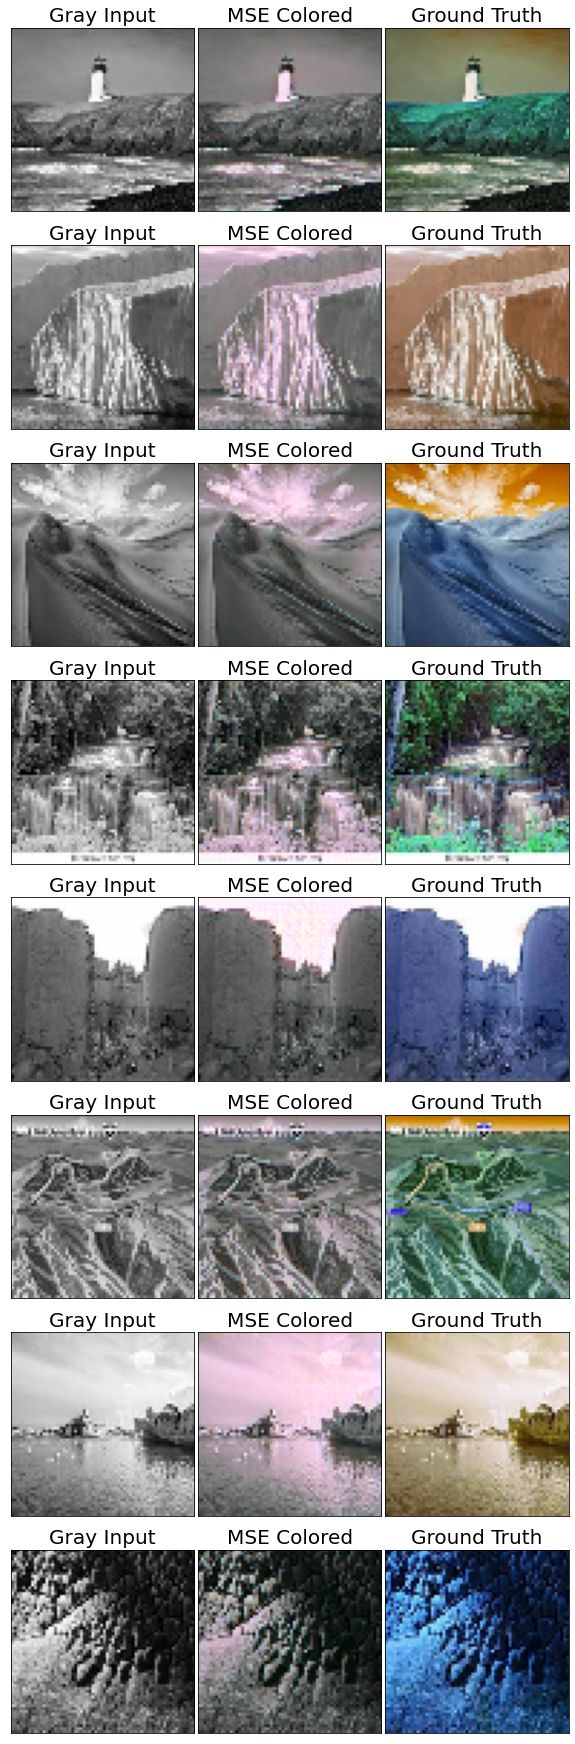

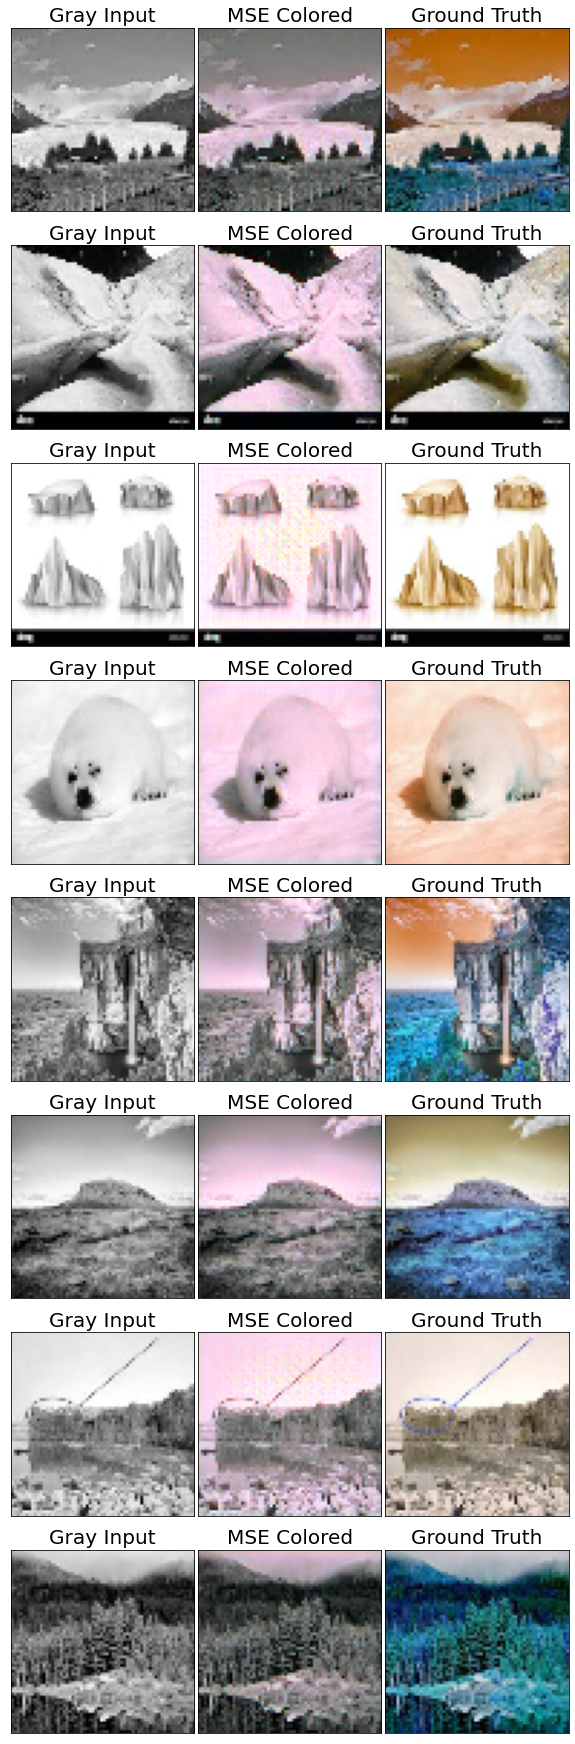

In [11]:
for train_batch in range(2):
    train_images = utils.image_loader(directory='../images/train_images/',
        batch_size=8,training=False).__getitem__(train_batch)
    utils.display_images(gray_channel=train_images[0],color_channels=train_images[1],generator1=generator,gen1_title='MSE Colored');

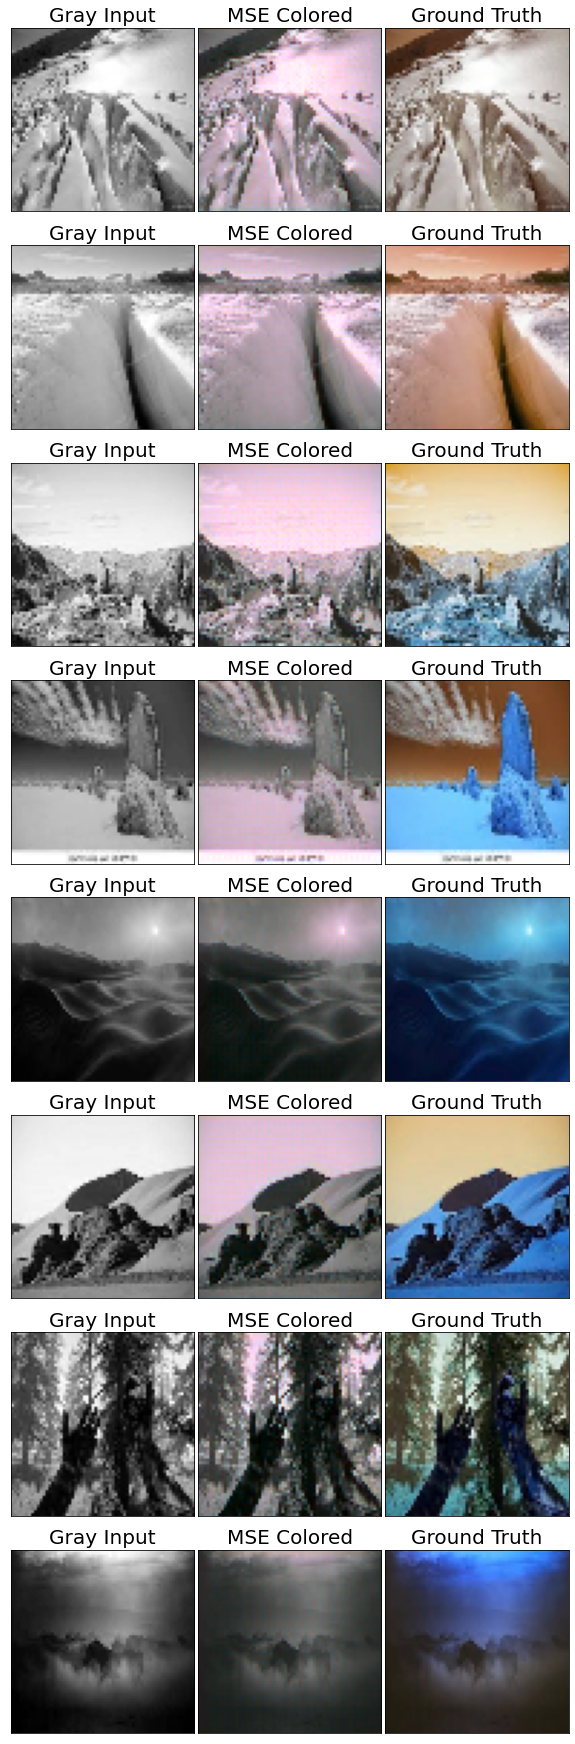

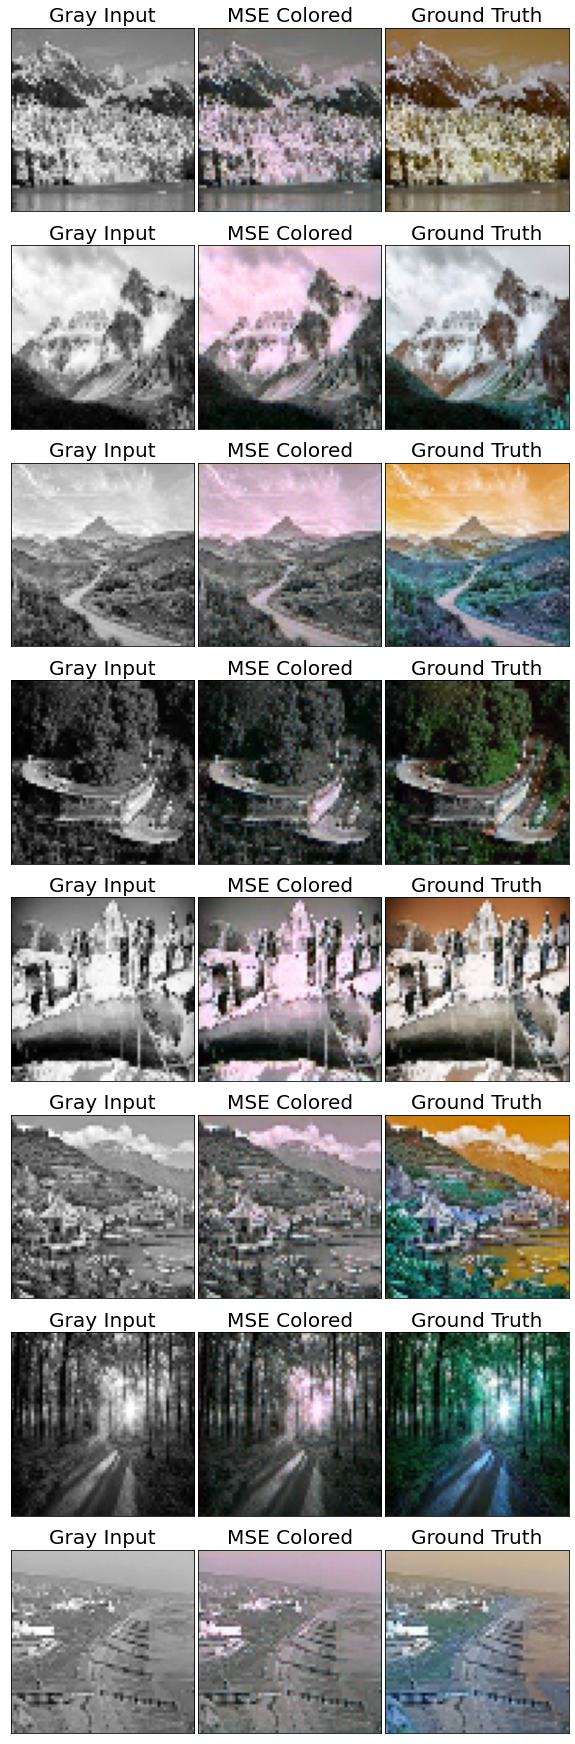

In [12]:
for val_batch in range(2):
    val_images = utils.image_loader(directory='../images/val_images/',
        batch_size=8,training=False).__getitem__(val_batch)
    utils.display_images(gray_channel=val_images[0],color_channels=val_images[1],generator1=generator,gen1_title='MSE Colored');